In [1]:
import pandas as pd
import requests
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import re
import gensim
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train_tweet.csv')
test = pd.read_csv('data/test_tweets.csv')

In [3]:
def preprocess(tweet):
    result = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    result = re.sub(r'(@[A-Za-z0-9-_]+)', '', result)
    result = re.sub(r'http\S+', '', result)
    result = re.sub(r'bit.ly/\S+', '', result) 
    result = re.sub(r'&[\S]+?;', '', result)
    result = re.sub(r'#', ' ', result)
    result = re.sub(r'[^\w\s]', r'', result)    
    result = re.sub(r'\w*\d\w*', r'', result)
    result = re.sub(r'\s\s+', ' ', result)
    result = re.sub(r'(\A\s+|\s+\Z)', '', result)
    result = tokenize(result)
    return result 

def lemmatize(token):
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:  # drops stopwords and words with <3 characters
            result.append(lemmatize(token))
    result = ' '.join(result)
    return result

In [4]:
train_processed = train['tweet'].apply(lambda x: preprocess(x))
train_processed.head()

0    father dysfunctional selfish drag kid dysfunct...
1    thank lyft credit use cause dont offer wheelch...
2                                       bihday majesty
3                         model love time urð ðððð ððð
4                        factsguide society motivation
Name: tweet, dtype: object

In [5]:
def aps(X, y, model):
    probs = model.decision_function(X)
    return average_precision_score(y, probs)

def auc(X, y, model):
    probs = model.decision_function(X) 
    return roc_auc_score(y, probs)

def get_metrics(X, y, y_pred, model):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rocauc = auc(X, y, model)
    prauc = aps(X, y, model)
    
    print('Accuracy: ', acc)
    print('F1: ', f1)
    print('Recall: ', rec)
    print('Precision: ', prec)
    print('ROC-AUC: ', rocauc)
    print('PR-AUC: ', prauc)

def get_confusion(y, y_pred):
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

In [6]:
x = train_processed
y = train.iloc[:, 1]

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25)

In [8]:
# X_tr = train_processed.values
# X_val = valid_processed.values
# y_tr = train.label.values
# y_val = valid.label.values

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(x_train)
tfidf_val = vec.transform(x_valid)

In [9]:
clf = LogisticRegression(C=10, penalty='l2', solver='lbfgs').fit(tfidf_tr, y_train)
y_pred = clf.predict(tfidf_val)
get_metrics(tfidf_val, y_valid, y_pred, clf)

Accuracy:  0.9633337504692779
F1:  0.6573099415204678
Recall:  0.525233644859813
Precision:  0.878125
ROC-AUC:  0.944472368737716
PR-AUC:  0.7547714453601951


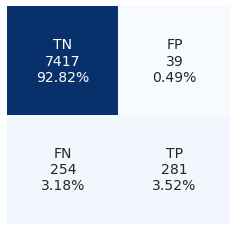

In [14]:
get_confusion(y_valid, y_pred)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(tfidf_tr, y_train)
rf_y_pred = rf.predict(tfidf_val)

print("Training Accuracy :", rf.score(tfidf_tr, y_train))
print("Validation Accuracy :", rf.score(tfidf_val, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, rf_y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, rf_y_pred)
print(cm)

Training Accuracy : 0.9999165658504026
Validation Accuracy : 0.9614566387185584
F1 score : 0.6342042755344418
[[7416   40]
 [ 268  267]]


In [11]:
pickle.dump(clf, open("model1.pkl", "wb"))

In [15]:
pickle.dump(rf, open("model2.pkl", "wb"))

In [12]:
pickle.dump(vec, open("vec1.pkl", "wb"))

In [19]:
def make_prediction(tweet):
    model = pickle.load(open("model1.pkl", "rb"))
    processed = preprocess(tweet)
    lst = []
    lst.append(processed)
    vec = pickle.load(open("vec1.pkl", "rb"))
    vectorized = vec.transform(lst)
    pred = model.predict(vectorized)
    prob = model.predict_proba(vectorized)[:,1]
    mapping = {0: 'Same tweet, different day. Keep it movin\'.', 1: 'Didn\'t your parents ever wash your mouth out with SOAP?  Well they should!'}
    prediction = mapping[pred[0]]
    probability = str(prob)[1:-1]
    return tweet, prediction, probability

In [20]:
str1 = "@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew &amp;… https://t.co/cuzxJAzFGL" 
str2 = "@user lol speak for your own hazara(mongol) people who have nothing to do with ethnic afghans (nor genetical\u2026 @URL"
str3 = "i am going to the store to get some broccoli and cheese, any suggestions on cheese?"
str4 = "@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew fuck you hate you black people"

In [21]:
make_prediction(str1)

('@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew &amp;… https://t.co/cuzxJAzFGL',
 "Didn't your parents ever wash your mouth out with SOAP?  Well they should!",
 '0.74614851')

In [22]:
make_prediction(str2)

('@user lol speak for your own hazara(mongol) people who have nothing to do with ethnic afghans (nor genetical… @URL',
 "Same tweet, different day. Keep it movin'.",
 '0.06903526')

In [23]:
make_prediction(str3)

('i am going to the store to get some broccoli and cheese, any suggestions on cheese?',
 "Same tweet, different day. Keep it movin'.",
 '0.01962575')

In [24]:
make_prediction(str4)

('@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew fuck you hate you black people',
 "Didn't your parents ever wash your mouth out with SOAP?  Well they should!",
 '0.98074704')

In [25]:
make_prediction("Black niggas be so motherfuckers hate them and fuck them ewwwwww white people are the better ones")

('Black niggas be so motherfuckers hate them and fuck them ewwwwww white people are the better ones',
 "Didn't your parents ever wash your mouth out with SOAP?  Well they should!",
 '0.86416527')

In [26]:
make_prediction("You so ugly I want you to take your fat ass from here and go die you black nigga")

('You so ugly I want you to take your fat ass from here and go die you black nigga',
 "Didn't your parents ever wash your mouth out with SOAP?  Well they should!",
 '0.62502547')

In [27]:
make_prediction("i love you")

('i love you', "Same tweet, different day. Keep it movin'.", '0.00057558')